In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyextremes import EVA

print("Todos los paquetes importados correctamente")


Todos los paquetes importados correctamente


In [18]:
station = 520
# We create some random continuous time series with some extremes
flowdata = pd.read_csv(f"../../../Status_Outlook_Bulletin/stations/data/{station}.csv",parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")
# Convertir el índice a datetime por si acaso
flowdata.index = pd.to_datetime(flowdata.index, dayfirst=True)
diff = pd.date_range(start = flowdata.index[0].strftime('%Y-%m-%d'), end = flowdata.index[-1].strftime('%Y-%m-%d'),freq='D')
# Re-index the dataframe based on the missind date variable
flowdata = flowdata.reindex(diff,fill_value=None)
# Set index Fecha
flowdata.index.name = 'Fecha'
flowdata = flowdata.rename_axis("date")
# Change columns names
flowdata.columns = ['flow']

#month and year column
flowdata['month'] = flowdata.index.month
flowdata['year'] = flowdata.index.year
flowdata = flowdata.reset_index()

#check whether or not there is enough data? 
print(station)
print(f"There are {flowdata['year'].max() - flowdata['year'].min()} years of data in this file.")
print(f"There are {sum(flowdata['flow'].isnull())} missing data points, which is {np.round(sum(flowdata['flow'].isnull())/len(flowdata) * 100,2)}% of the total data")

520
There are 45 years of data in this file.
There are 153 missing data points, which is 0.93% of the total data


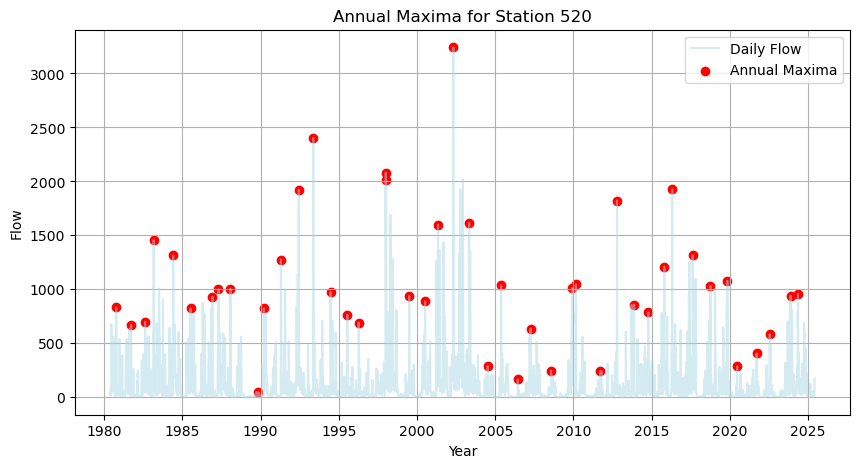

In [19]:
# Prepare the time series: set 'date' as index and use the 'flow' column
flowdata_ts = flowdata.set_index('date')['flow'].dropna()

# Agrupar los datos por año y encontrar la fecha del máximo
max_dates = flowdata_ts.groupby(flowdata_ts.index.year).idxmax()

# Usar las fechas encontradas para obtener los valores máximos
annual_maxima = flowdata_ts.loc[max_dates]

# Remover un año en especifico si no está completo
annual_maxima = annual_maxima[annual_maxima.index.year < 2025]

# Graficar annual maxima
plt.figure(figsize=(10, 5))
plt.plot(flowdata_ts.index, flowdata_ts.values, label='Daily Flow', color='lightblue', alpha=0.5)
plt.scatter(annual_maxima.index, annual_maxima.values, color='red', label='Annual Maxima')
plt.title(f'Annual Maxima for Station {station}')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.legend()
plt.grid()
plt.show()

In [20]:
model = EVA(flowdata_ts)

In [21]:
model.set_extremes(extremes=annual_maxima) 

In [22]:
model.fit_model()
summary = model.get_summary(
    return_period=[2, 5, 10, 20, 25, 50, 100, 250, 500, 1000,5000],
    alpha=0.95,
    n_samples=1000,
)
print(summary)

               return value     lower ci     upper ci
return period                                        
2.0              934.405033   776.603998  1114.689951
5.0             1496.440411  1252.907820  1781.886620
10.0            1865.549514  1550.795888  2224.809549
20.0            2218.916460  1824.954498  2652.108930
25.0            2330.936798  1914.188080  2789.720979
50.0            2675.897110  2188.919252  3202.806911
100.0           3018.204842  2459.625472  3611.371503
250.0           3468.835283  2813.198724  4168.142607
500.0           3809.071009  3076.567048  4588.652832
1000.0          4149.050776  3340.040045  4995.938172
5000.0          4938.070652  3950.961781  5945.171526


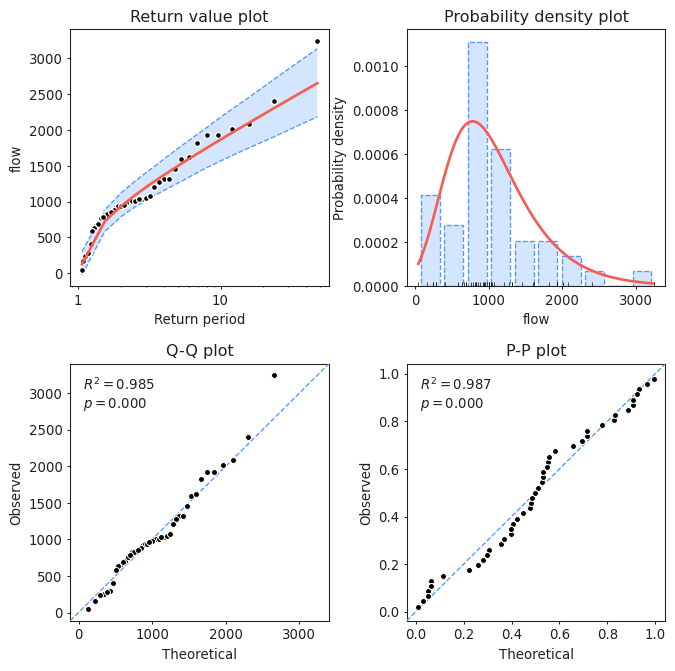

In [23]:
model.plot_diagnostic(alpha=0.95);
plt.show()

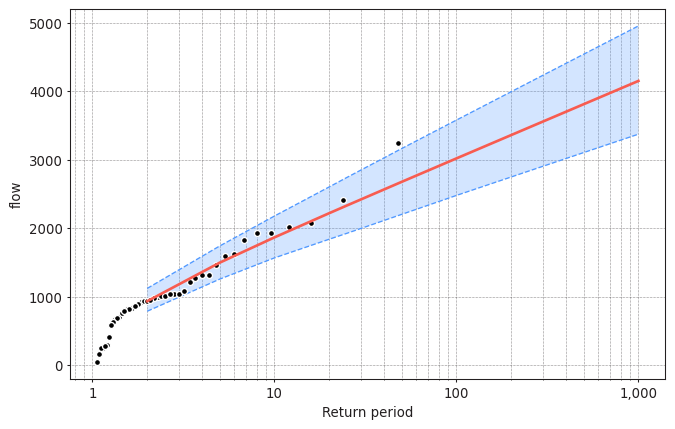

In [24]:
model.plot_return_values(alpha=0.95, return_period=[2, 5, 10, 20, 25, 50, 100, 250, 500, 1000]);
plt.show()

In [26]:
from pyextremes import get_return_periods

return_periods = get_return_periods(
    ts=flowdata_ts,
    extremes=annual_maxima,
    extremes_method="BM",
    extremes_type="high",
    block_size="365.2425D",
    return_period_size="365.2425D",
    plotting_position="weibull",        # other option: "Cunnane", "median", "Gringorten"
)
return_periods.sort_values("return period", ascending=False).head(12).round(2)

,flow,exceedance probability,return period
date,,,
2002-04-27,3243.47,0.02,46.00
1993-05-13,2404.26,0.04,23.00
1997-12-31,2082.18,0.07,15.33
1998-01-09,2015.80,0.09,11.50
2016-04-25,1925.99,0.11,9.20
1992-06-09,1923.84,0.13,7.67
2012-10-12,1822.68,0.15,6.57
2003-05-01,1616.99,0.17,5.75
2001-05-04,1598.61,0.20,5.11
